# **Histopathologic Cancer Detection (Kaggle)**

### **Project Objective**

To build a deep learning model that accurately identifies metastatic cancer tissue in 96x96px histopathologic image patches. The model must predict the probability that the center 32x32px region contains tumor tissue.

**Competition Metric:** ROC AUC

### **Project Workflow**

This notebook is designed to be flexible and supports two distinct run modes, managed by the CFG class:

1. **Training (on Google Colab Pro):**  
   * Set CFG.TRAINING \= True and CFG.INFERENCE \= False.  
   * Run on Colab Pro with high-performance GPUs (V100/A100) and High-RAM.  
   * Data will be downloaded via the Kaggle API to the local Colab VM.  
   * This mode will run the full K-Fold training and save the resulting model weights.  
   * Model weights (.h5 or .pth) should be manually saved (e.g., to Google Drive) and then uploaded as a private **Kaggle Dataset**.  
2. **Inference (on Kaggle Notebooks):**  
   * Set CFG.TRAINING \= False and CFG.INFERENCE \= True.  
   * This notebook will be run on the Kaggle platform for submission.  
   * It will **not** run training.  
   * It will load the pre-trained model weights from the private Kaggle Dataset created in Step 1\.  
   * It will run inference (with TTA) on the official test/ dataset and generate submission.csv.

## 1. Setup & Configuration
This central CFG (Configuration) class holds all hyperparameters and environment settings.

In [1]:
# [CODE CELL]
class CFG:
    # --- Workflow Control ---
    # Set to True on Colab Pro for training
    TRAINING = True
    # Set to True on Kaggle for submission
    INFERENCE = False
    # Set to True for a quick run on a small data sample
    DEBUG = False

    # --- Environment ---
    PLATFORM = "Colab" # "Kaggle" or "Colab"
    SEED = 42

    # --- Data ---
    IMAGE_SIZE = (96, 96)
    N_CHANNELS = 3

    # --- Model ---
    MODEL_NAME = 'EfficientNetB0' # e.g., 'EfficientNetB0', 'ResNet50'
    PRETRAINED_WEIGHTS = 'imagenet'

    # --- Training ---
    N_FOLDS = 5
    EPOCHS = 20
    BATCH_SIZE = 64
    LEARNING_RATE = 1e-4
    LR_REDUCE_PATIENCE = 3
    EARLY_STOPPING_PATIENCE = 5

    # --- TTA (Test Time Augmentation) ---
    TTA_STEPS = 5 # Number of augmented predictions to average (incl. original)

# --- Utility Function for Seeding ---
def seed_everything(seed=CFG.SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)


In [2]:
# [CODE CELL]
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import random

print(f"TensorFlow Version: {tf.__version__}")


TensorFlow Version: 2.19.0


## Data Setup

In [3]:
# --- Define Paths ---
if CFG.PLATFORM == "Kaggle":
    # Running on Kaggle, data is pre-mounted
    BASE_PATH = "/kaggle/input/histopathologic-cancer-detection"
    MODEL_WEIGHTS_PATH = "/kaggle/input/my-cancer-model-weights" # Path to your private Kaggle Dataset

elif CFG.PLATFORM == "Colab":
    from google.colab import drive
    import os

    # 1. 挂载 Google Drive
    print("正在挂载 Google Drive...")
    drive.mount('/content/drive')

    # --- 2. 定义路径 ---
    # 你在 Drive 上的 ZIP 文件路径 (根据你的截图)
    GDRIVE_ZIP_PATH = "/content/drive/MyDrive/Kaggle_Datasets/histopathologic-cancer/histopathologic-cancer-detection.zip"

    # 我们要解压到 Colab 本地的临时路径
    LOCAL_DATA_PATH = "/content/data"

    # 我们用标签文件作为“是否已解压”的检查点
    CHECK_FILE_PATH = os.path.join(LOCAL_DATA_PATH, "train_labels.csv")

    # --- 3. 检查是否已解压，如果未解压，则执行解压 ---
    # 这样你重新运行单元格时，如果文件已在，就不用浪费时间再次解压
    if not os.path.exists(CHECK_FILE_PATH):
        print(f"在 {LOCAL_DATA_PATH} 未找到数据...")
        print(f"正在从 Google Drive ({GDRIVE_ZIP_PATH}) 解压文件...")

        # 确保目标目录存在
        os.makedirs(LOCAL_DATA_PATH, exist_ok=True)

        # 从 Drive 解压到 Colab 本地 (-q 参数是“安静模式”，减少输出)
        !unzip -q "$GDRIVE_ZIP_PATH" -d "$LOCAL_DATA_PATH"

        print("解压完成！")
    else:
        print(f"数据已存在于 {LOCAL_DATA_PATH}。跳过解压。")

    # --- 4. 设置你代码中使用的路径 ---
    # BASE_PATH 现在指向 Colab 的本地路径
    BASE_PATH = LOCAL_DATA_PATH

    # 模型权重路径 (你原来的设置很好，保持在 Drive 上)
    MODEL_WEIGHTS_PATH = "/content/drive/MyDrive/Kaggle/PADCancer/weights"
    if not os.path.exists(MODEL_WEIGHTS_PATH):
        os.makedirs(MODEL_WEIGHTS_PATH)

TRAIN_PATH = os.path.join(BASE_PATH, "train")
TEST_PATH = os.path.join(BASE_PATH, "test")
LABELS_PATH = os.path.join(BASE_PATH, "train_labels.csv")

# --- Load Labels ---
df_labels = pd.read_csv(LABELS_PATH)

# Add image file path
df_labels['file_path'] = df_labels['id'].apply(lambda x: os.path.join(TRAIN_PATH, x + '.tif'))
# Convert label to string for flow_from_dataframe
df_labels['label_str'] = df_labels['label'].astype(str)

# --- Debug Mode ---
if CFG.DEBUG:
    print("--- DEBUG MODE ENABLED ---")
    # Use a small, stratified sample
    _, df_labels = train_test_split(
        df_labels,
        test_size=0.01,
        stratify=df_labels['label'],
        random_state=CFG.SEED
    )
    print(f"Running in debug mode with {len(df_labels)} samples.")

print(f"Total training samples: {len(df_labels)}")
df_labels.head()

正在挂载 Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
数据已存在于 /content/data。跳过解压。
Total training samples: 220025


,id,label,file_path,label_str
0,f38a6374c348f90b587e046aac6079959adf3835,0,/content/data/train/f38a6374c348f90b587e046aac...,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,/content/data/train/c18f2d887b7ae4f6742ee44511...,1
2,755db6279dae599ebb4d39a9123cce439965282d,0,/content/data/train/755db6279dae599ebb4d39a912...,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,/content/data/train/bc3f0c64fb968ff4a8bd33af69...,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0,/content/data/train/068aba587a4950175d04c680d3...,0


## **3\. EDA**

**Check if the dataset is balanced.**

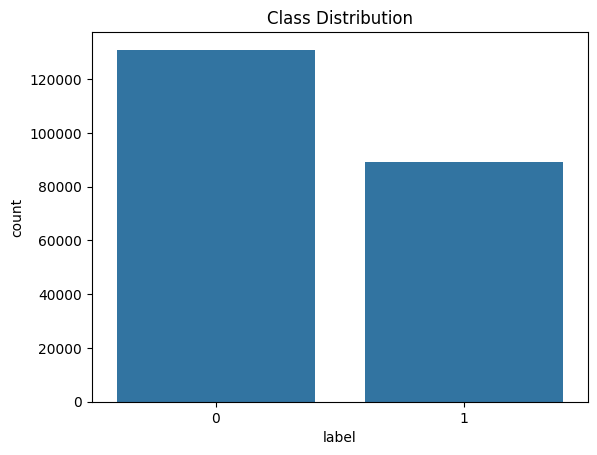

label
0    0.594969
1    0.405031
Name: proportion, dtype: float64


In [4]:
# [CODE CELL]
sns.countplot(x='label', data=df_labels)
plt.title('Class Distribution')
plt.show()
print(df_labels['label'].value_counts(normalize=True))


**View Sample Images**

Visualize some positive and negative samples.

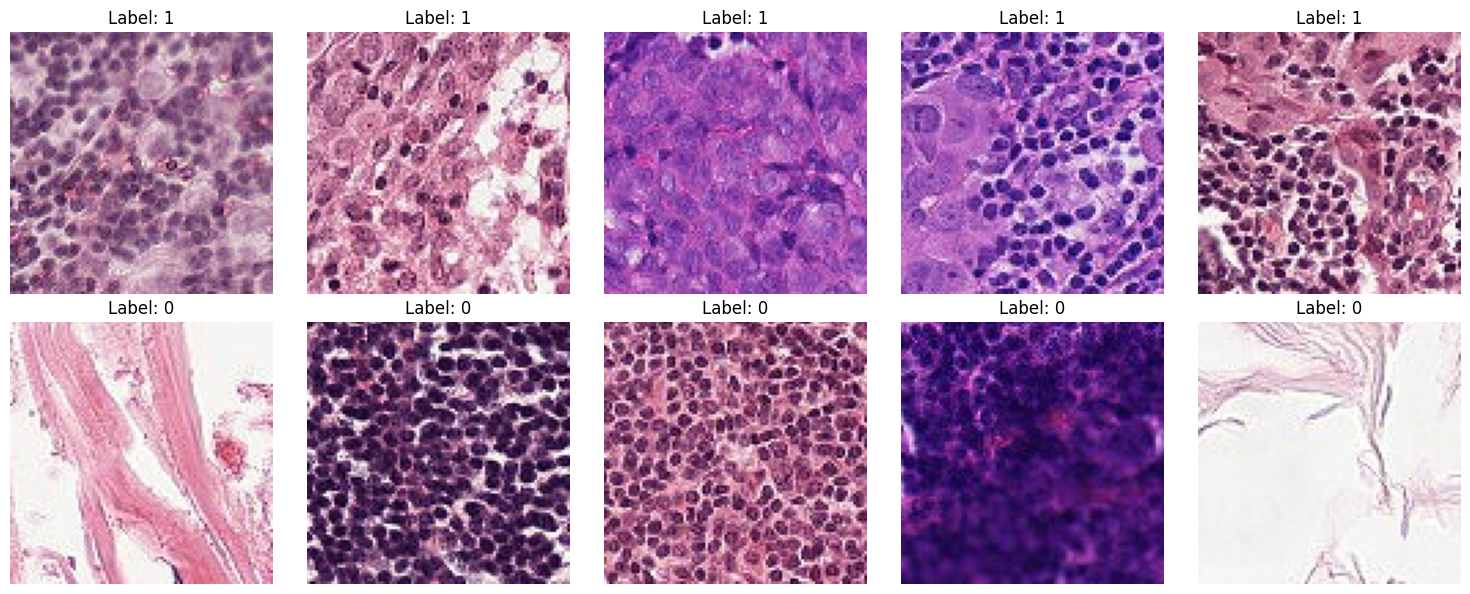

In [5]:
# [CODE CELL]
# ... (Code to plot sample images) ...
def plot_samples(df, n=5):
    """Plots n positive and n negative samples."""
    pos_samples = df[df['label'] == 1]['file_path'].sample(n, random_state=CFG.SEED).values
    neg_samples = df[df['label'] == 0]['file_path'].sample(n, random_state=CFG.SEED).values

    fig, axes = plt.subplots(2, n, figsize=(n*3, 6))

    for i in range(n):
        # Plot positive samples
        img_pos = plt.imread(pos_samples[i])
        axes[0, i].imshow(img_pos)
        axes[0, i].set_title("Label: 1")
        axes[0, i].axis('off')

        # Plot negative samples
        img_neg = plt.imread(neg_samples[i])
        axes[1, i].imshow(img_neg)
        axes[1, i].set_title("Label: 0")
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

# Plot samples (only if not in debug mode, or if debug df is large enough)
if len(df_labels) > 10:
    plot_samples(df_labels)
else:
    print("Skipping sample plotting due to small debug dataframe.")

**Data Cleaning**

This dataset is known to contain anomalies (e.g., blank slides, slides with markers, duplicates). A simple cleaning step is to remove images with very low variance, as they are often blank.

Starting data cleaning (calculating variance)... This may take a while.
Utilizing 12 CPU cores for parallel variance calculation.


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:    0.5s
[Parallel(n_jobs=12)]: Done 492 tasks      | elapsed:    0.7s
[Parallel(n_jobs=12)]: Done 18444 tasks      | elapsed:    1.2s
[Parallel(n_jobs=12)]: Done 178188 tasks      | elapsed:    5.9s
[Parallel(n_jobs=12)]: Done 220025 out of 220025 | elapsed:    6.8s finished


Variance calculation complete.
Displaying 10 samples with the lowest variance...


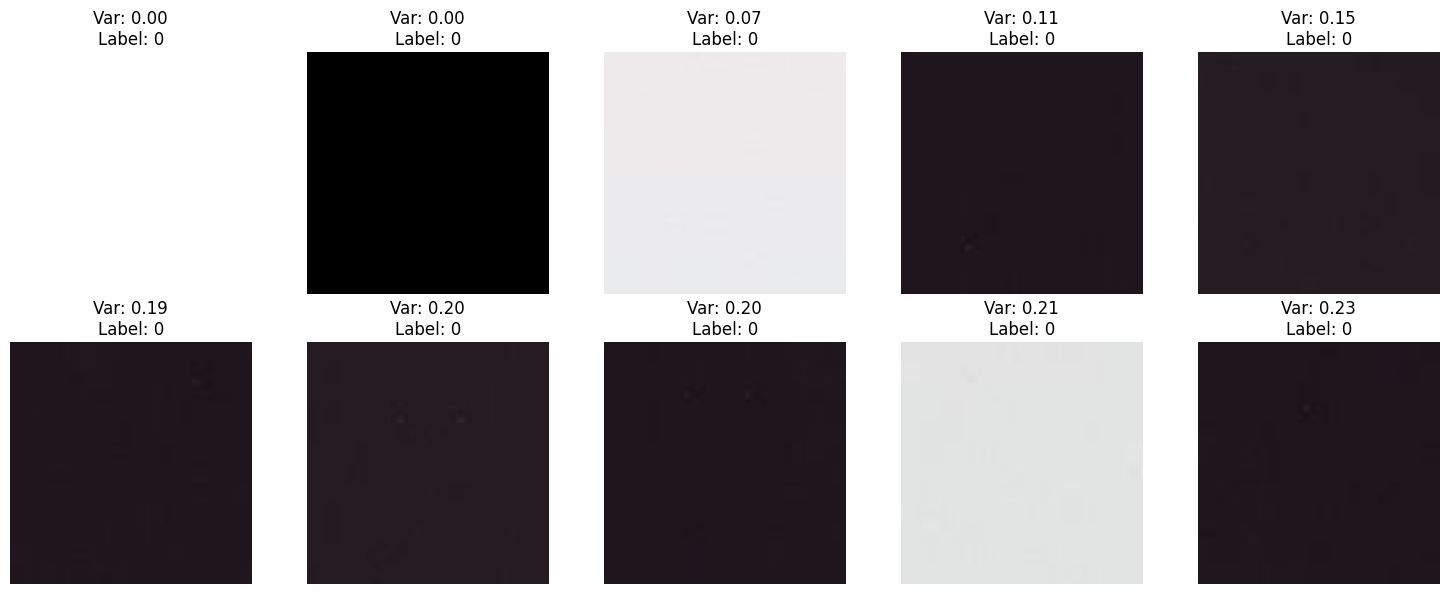

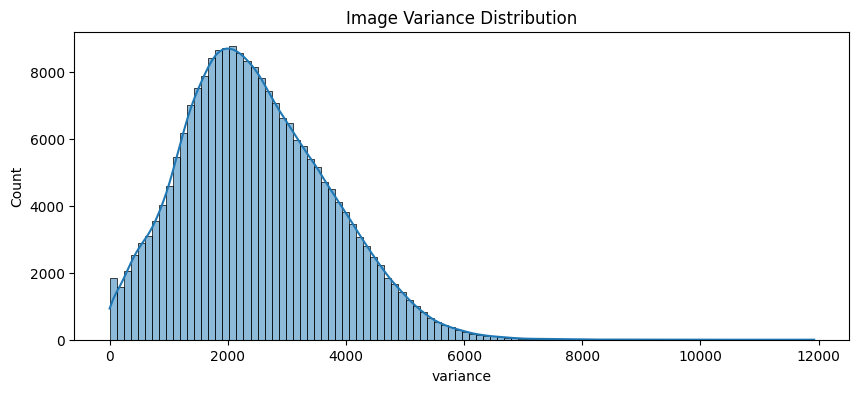

--- Data Cleaning Report ---
Original sample count (df_labels): 220025
Removed 1634 low-variance images (var < 100).
New sample count (df_labels_clean): 218391


In [6]:
# [CODE CELL]
import cv2 # <-- 重新导入以确保此单元格能独立运行
from joblib import Parallel, delayed # <-- 导入 Joblib
import os # <-- 导入 os 以获取 CPU 核心数
import matplotlib.pyplot as plt # <-- 导入 plt

# This step can be slow. For a quick run (DEBUG=True), we might skip it or run on the sample.
# For the full dataset, this should be run once.

def get_image_variance(image_path):
    """Calculates the variance of a single image."""
    try:
        # Read image in grayscale which is enough for variance calculation
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            return 0
        return image.var()
    except Exception as e:
        print(f"Error reading {image_path}: {e}")
        return 0

if CFG.TRAINING and not CFG.DEBUG:
    print("Starting data cleaning (calculating variance)... This may take a while.")

    # --- 优化：并行处理 ---
    # 利用 Colab Pro 的多核心 CPU 和高 RAM
    # 替代慢速的: df_labels['file_path'].apply(get_image_variance)

    n_cores = os.cpu_count()
    print(f"Utilizing {n_cores} CPU cores for parallel variance calculation.")

    paths_to_process = df_labels['file_path'].values

    # 使用 joblib 并行运行, verbose=5 会显示进度
    variances = Parallel(n_jobs=n_cores, verbose=5)(
        delayed(get_image_variance)(path) for path in paths_to_process
    )

    # 将结果分配回 dataframe
    df_labels['variance'] = variances

    print("Variance calculation complete.")

    # --- 1. (新增) 可视化方差最低的10个样本 ---
    print("Displaying 10 samples with the lowest variance...")
    low_variance_samples = df_labels.sort_values(by='variance').head(10)

    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()
    for i, (idx, row) in enumerate(low_variance_samples.iterrows()):
        try:
            img = plt.imread(row['file_path'])
            axes[i].imshow(img)
            axes[i].set_title(f"Var: {row['variance']:.2f}\nLabel: {row['label']}")
            axes[i].axis('off')
        except Exception as e:
            axes[i].set_title(f"Error loading img: {row['id']}")
            print(e)
    plt.tight_layout()
    plt.show()

    # Plot variance distribution
    plt.figure(figsize=(10, 4))
    sns.histplot(df_labels['variance'], bins=100, kde=True)
    plt.title('Image Variance Distribution')
    plt.show()

    # --- 2. (修改) 过滤低方差图像并使用新变量 ---
    VARIANCE_THRESHOLD = 100 # This is a common threshold, can be tuned
    original_count = len(df_labels)

    # 将清理后的数据存储在新 DataFrame 'df_labels_clean' 中
    df_labels_clean = df_labels[df_labels['variance'] > VARIANCE_THRESHOLD].reset_index(drop=True)
    new_count = len(df_labels_clean)

    print(f"--- Data Cleaning Report ---")
    print(f"Original sample count (df_labels): {original_count}")
    print(f"Removed {original_count - new_count} low-variance images (var < {VARIANCE_THRESHOLD}).")
    print(f"New sample count (df_labels_clean): {new_count}")

elif CFG.DEBUG:
    print("Skipping data cleaning in DEBUG mode.")
    df_labels_clean = df_labels.copy() # 在调试模式下，clean 版本就是原始版本
else:
    print("Skipping data cleaning (not in TRAINING mode).")
    df_labels_clean = df_labels.copy() # 在非训练模式下，clean 版本就是原始版本


## **4. Validation Strategy**

Define the K-Fold validation split.


In [7]:
# [CODE CELL]
skf = StratifiedKFold(n_splits=CFG.N_FOLDS, shuffle=True, random_state=CFG.SEED)

# Create a new 'fold' column
df_labels['fold'] = -1
for fold, (train_idx, val_idx) in enumerate(skf.split(df_labels, df_labels['label'])):
    df_labels.loc[val_idx, 'fold'] = fold

print("Fold distribution created.")
df_labels.head()

Fold distribution created.


,id,label,file_path,label_str,variance,fold
0,f38a6374c348f90b587e046aac6079959adf3835,0,/content/data/train/f38a6374c348f90b587e046aac...,0,1261.534750,2
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,/content/data/train/c18f2d887b7ae4f6742ee44511...,1,2225.526618,0
2,755db6279dae599ebb4d39a9123cce439965282d,0,/content/data/train/755db6279dae599ebb4d39a912...,0,3183.458707,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,/content/data/train/bc3f0c64fb968ff4a8bd33af69...,0,2081.470201,3
4,068aba587a4950175d04c680d38943fd488d6a9d,0,/content/data/train/068aba587a4950175d04c680d3...,0,2839.813050,3


## **5. Data Augmentation & Pipeline**

Define the augmentations and create the Keras Data Generators.

In [8]:
# --- Augmentations ---
# For training: heavy augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255.,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=45,
    brightness_range=[0.8, 1.2],
    # contrast_range=[0.8, 1.2], # Removed this argument
    fill_mode='reflect'
)

# For validation/testing: only rescaling
val_datagen = ImageDataGenerator(rescale=1./255.)

# --- Data Generator Functions ---
# We will create generators inside the training loop

def get_train_generator(df, fold):
    train_df = df[df['fold'] != fold]
    return train_datagen.flow_from_dataframe(
        train_df,
        x_col='file_path',
        y_col='label_str',
        target_size=CFG.IMAGE_SIZE,
        batch_size=CFG.BATCH_SIZE,
        class_mode='binary',
        shuffle=True,
        seed=CFG.SEED
    )

def get_val_generator(df, fold):
    val_df = df[df['fold'] == fold]
    return val_datagen.flow_from_dataframe(
        val_df,
        x_col='file_path',
        y_col='label_str',
        target_size=CFG.IMAGE_SIZE,
        batch_size=CFG.BATCH_SIZE,
        class_mode='binary',
        shuffle=False # No shuffle for validation
    )

## **6. Model Definition**

Define the function to build our CNN.

In [9]:
# [CODE CELL]
def build_model():
    # Load base model
    base_model = EfficientNetB0(
        include_top=False,
        weights=CFG.PRETRAINED_WEIGHTS,
        input_shape=(*CFG.IMAGE_SIZE, CFG.N_CHANNELS)
    )

    # Freeze base model initially
    base_model.trainable = False

    # Add classification head
    inputs = tf.keras.Input(shape=(*CFG.IMAGE_SIZE, CFG.N_CHANNELS))
    x = base_model(inputs, training=False) # Set training=False for batch norm
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)

    # Compile
    model.compile(
        optimizer=Adam(learning_rate=CFG.LEARNING_RATE),
        loss='binary_crossentropy',
        metrics=[tf.keras.metrics.AUC(name='auc')]
    )

    return model

# --- Test build ---
model = build_model()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 3, 3, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,050,852 (15.45 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

## **7. Training**

This section will only run if CFG.TRAINING is True.


In [10]:
# [CODE CELL]
if CFG.TRAINING:
    print("--- STARTING TRAINING ---")
    oof_predictions = []
    oof_labels = []

    for fold in range(CFG.N_FOLDS):
        print(f"\n--- Fold {fold+1}/{CFG.N_FOLDS} ---")

        # 1. Get Data
        train_gen = get_train_generator(df_labels, fold)
        val_gen = get_val_generator(df_labels, fold)

        # 2. Build Model
        tf.keras.backend.clear_session()
        model = build_model()

        # 3. Callbacks
        model_save_path = os.path.join(MODEL_WEIGHTS_PATH, f"model_fold_{fold}.weights.h5") # Changed file extension
        callbacks = [
            ModelCheckpoint(
                model_save_path,
                monitor='val_auc',
                mode='max',
                save_best_only=True,
                save_weights_only=True
            ),
            ReduceLROnPlateau(
                monitor='val_auc',
                mode='max',
                factor=0.1,
                patience=CFG.LR_REDUCE_PATIENCE,
                verbose=1
            ),
            EarlyStopping(
                monitor='val_auc',
                mode='max',
                patience=CFG.EARLY_STOPPING_PATIENCE,
                verbose=1,
                restore_best_weights=True
            )
        ]

        # 4. Train
        history = model.fit(
            train_gen,
            steps_per_epoch=len(train_gen),
            validation_data=val_gen,
            validation_steps=len(val_gen),
            epochs=CFG.EPOCHS,
            callbacks=callbacks
        )

        # 5. Store OOF (Out-of-Fold) Predictions
        print(f"Loading best weights for fold {fold} from {model_save_path}")
        model.load_weights(model_save_path)

        val_df = df_labels[df_labels['fold'] == fold]
        oof_preds = model.predict(val_gen, steps=len(val_gen), verbose=1)

        oof_predictions.extend(oof_preds.flatten())
        oof_labels.extend(val_df['label'].values)

        # --- Plot History ---
        # ... (Code to plot training/validation AUC and Loss vs. Epochs) ...

    # --- Overall OOF Score ---
    oof_auc = roc_auc_score(oof_labels, oof_predictions)
    print(f"\n--- Overall OOF AUC = {oof_auc:.5f} ---")

else:
    print("--- TRAINING SKIPPED (CFG.TRAINING = False) ---")

--- STARTING TRAINING ---

--- Fold 1/5 ---
Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


KeyboardInterrupt: 

## **8. Inference & Submission**

This section will only run if CFG.INFERENCE is True.


In [ ]:
# [CODE CELL]
if CFG.INFERENCE:
    print("--- STARTING INFERENCE ---")

    # 1. Load Trained Models
    models = []
    for fold in range(CFG.N_FOLDS):
        model_path = os.path.join(MODEL_WEIGHTS_PATH, f"model_fold_{fold}.h5")
        if not os.path.exists(model_path):
            print(f"ERROR: Model weight not found at {model_path}")
            # Handle error

        print(f"Loading model from {model_path}")
        tf.keras.backend.clear_session()
        model = build_model()
        model.load_weights(model_path)
        models.append(model)

    print(f"Loaded {len(models)} models for inference.")

    # 2. Setup Test Data
    df_sub = pd.read_csv(os.path.join(BASE_PATH, 'sample_submission.csv'))
    df_sub['file_path'] = df_sub['id'].apply(lambda x: os.path.join(TEST_PATH, x + '.tif'))

    test_datagen = ImageDataGenerator(rescale=1./255.)
    test_gen = test_datagen.flow_from_dataframe(
        df_sub,
        x_col='file_path',
        y_col=None,
        target_size=CFG.IMAGE_SIZE,
        batch_size=CFG.BATCH_SIZE,
        class_mode=None,
        shuffle=False
    )

    # 3. TTA (Test Time Augmentation) Generator
    # Note: For TTA, it's often easier to write a custom generator or
    # manually load and augment each image in the prediction loop.
    # For simplicity, we'll start with non-TTA predictions.

    # 4. Predict
    all_preds = []
    for model in models:
        print("Predicting with model...")
        preds = model.predict(test_gen, steps=len(test_gen), verbose=1)
        all_preds.append(preds.flatten())

    # Average predictions across all K-Fold models
    final_preds = np.mean(all_preds, axis=0)

    # 5. Create Submission File
    df_sub['label'] = final_preds
    df_sub = df_sub[['id', 'label']]
    df_sub.to_csv('submission.csv', index=False)

    print("Submission file created!")
    print(df_sub.head())

else:
    print("--- INFERENCE SKIPPED (CFG.INFERENCE = False) ---")

